In [1]:
import numpy as np
import porespy as ps
import matplotlib.pyplot as plt
import scipy.io as sio
import skimage as ski
import tqdm
import seaborn as sns
import pandas as pd
from pathlib import Path
import pickle as pkl
from  scipy.stats import gaussian_kde


cwd = Path().resolve()

In [2]:
# Define overall variables used to analyze the data
resolution = 16.81E-6 # adding resolution in meters
lowFlowVelCutoff = 6.5 * 10 ** float(-6) #0.000207 # 5.13 * 10 ** float(-5) # 0.5 * 10 ** float(-5)
poreDiamThresh = 20
poreVolumeCutoff = 38000
simPressure = 0.00005 # This is currently hardcoded!!
imageSize = 512
experimentTime = 90 * 10 ** float(-6) # specify NMR time

filePath = cwd / 'subBeadPackPy512_justSpheres.npy'
primaryImage = np.load(filePath)

filePath = cwd / 'finalSimFile3D512.npy'
secondaryImage = np.load(filePath)
primaryImage[primaryImage == 255] = 1

primaryImage = np.transpose(primaryImage)
secondaryImage = np.transpose(secondaryImage)

filePath = cwd / 'primarySnowOut.npy'
primarySnow = np.load(filePath)
filePath = cwd / 'primaryPoreInfo.p'
#primaryInfo = np.load(filePath,allow_pickle=True)
poreInfoPrimary = pkl.load(open(filePath,'rb'))

filePath = cwd / 'secondarySnowOut.npy'
secondarySnow = np.load(filePath)
filePath = cwd / 'secondaryPoreInfo.p'
#secondaryInfo = np.load(filePath,allow_pickle=True)
poreInfoSecondary = pkl.load(open(filePath,"rb"))

In [4]:
filePath = cwd / 'velocityFiles' / 'velocityNormCodeSecondary_0.00005.mat'
velSecondaryMat = sio.loadmat(filePath)
velDataNormSecondary = velSecondaryMat['velNorm']

filePath = cwd / 'velocityFiles' / 'velocityNormCodePrimary_0.00005.mat'
velPrimaryMat = sio.loadmat(filePath)
velDataNormPrimary = velPrimaryMat['velNorm']


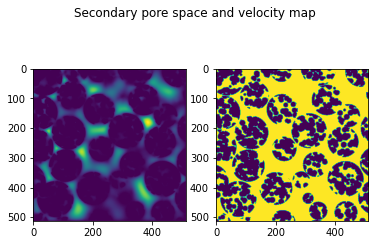

In [5]:
slice = 35

fig, (p1, p2) = plt.subplots(1, 2)

fig.suptitle('Secondary pore space and velocity map')
p1.imshow(velDataNormSecondary[:,:,slice])
p2.imshow(secondaryImage[:,:,slice])

fig.savefig('secondaryPoreImage.png', dpi=300, facecolor='w', edgecolor='w')

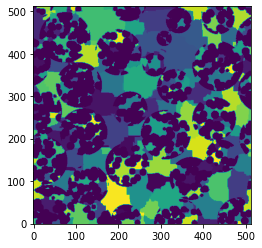

In [6]:
plt.imshow(ps.tools.randomize_colors(secondarySnow[:,:,slice]), origin='lower')
plt.savefig('secondaryRegions.png', dpi=300, facecolor='w', edgecolor='w')


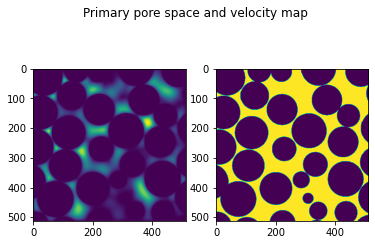

In [7]:
slice = 35

fig, (p1, p2) = plt.subplots(1, 2)

fig.suptitle('Primary pore space and velocity map')
p1.imshow(velDataNormPrimary[:,:,slice])
p2.imshow(primaryImage[:,:,slice])

fig.savefig('primaryPoreImage.png', dpi=300, facecolor='w', edgecolor='w')


### Generate primary porosity data

In [6]:
nRegions = np.unique(primarySnow).size
primaryPoreDiamVec = np.zeros(nRegions,)
primaryPoreVolumeVec = np.zeros(nRegions,)

for a in range(0, poreInfoPrimary['pore.diameter'].size):
    primaryPoreDiamVec[a] = poreInfoPrimary['pore.diameter'][a]
    primaryPoreVolumeVec[a] = poreInfoPrimary['pore.volume'][a]

primaryRegions = primarySnow

# Skeleton for primary image
cubeSize = len(primaryImage)
visit = np.zeros(len(np.unique(primaryRegions)))
primaryPoreDiamImage = np.zeros(primaryImage.shape)
allPrimaryRegions = np.unique(primaryRegions)
tempImage = np.zeros(primaryRegions.shape)
primaryPoreDiamVectorSkeleton = np.zeros(len(allPrimaryRegions))
primary_metric_PoreVelocity =  []
primaryMeanPoreVelocity =  []
primarySkeletonPoreDiam = []
primarySkeletonPoreRegion = []
primarySkeletonPoreVolume = []
primarySkelImage = ski.morphology.skeletonize(primaryImage)

# Save data on the skeleton
#primaryVelocitiesSkeleton = []
primaryPoreDiamSkeleton = []

primaryFiltSkelImage = np.where(primarySkelImage,True,False)
primaryVelocitiesSkeleton = velDataNormPrimary[primaryFiltSkelImage]
primaryPoreRegionSkeleton = primaryRegions[primaryFiltSkelImage]

for a in tqdm.tqdm(range(0,len(allPrimaryRegions)), 'Primary Regions loop'):
            currentRegion = a
            if currentRegion != 0: # Don't want grains to be counted
                if visit[currentRegion] == 0:
                    visit[currentRegion] = 1

                    regionImage = np.where(primaryPoreRegionSkeleton == currentRegion)
                    skeletonPoreVel = primaryVelocitiesSkeleton[regionImage]

                    primaryMeanPoreVelocity = np.append(primaryMeanPoreVelocity, np.mean(skeletonPoreVel))
                    primary_metric_PoreVelocity = np.append(primary_metric_PoreVelocity, np.median(skeletonPoreVel))

                    # Adjust indices between regionProps and snow algorithm
                    primarySkeletonPoreDiam = np.append(primarySkeletonPoreDiam,
                                                        poreInfoPrimary['pore.diameter'][currentRegion - 1])
                    primarySkeletonPoreVolume = np.append(primarySkeletonPoreVolume,
                                                          poreInfoPrimary['pore.volume'][currentRegion - 1])

                    primarySkeletonPoreRegion = np.append(primarySkeletonPoreRegion, currentRegion)


Primary Regions loop:   0%|          | 0/544 [00:00<?, ?it/s]E:\Conda\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
Primary Regions loop: 100%|██████████| 544/544 [00:00<00:00, 2845.84it/s]


### Generate secondary porosity data


In [7]:
nRegions = np.unique(secondarySnow).size
secondaryPoreDiamVec = np.zeros(nRegions,)
secondaryPoreVolumeVec = np.zeros(nRegions,)

for a in range(0, poreInfoSecondary['pore.diameter'].size):
    secondaryPoreDiamVec[a] = poreInfoSecondary['pore.diameter'][a]
    secondaryPoreVolumeVec[a] = poreInfoSecondary['pore.volume'][a]

secondaryRegions = secondarySnow

# Skeleton for secondary image
cubeSize = len(secondaryImage)
visit = np.zeros(len(np.unique(secondaryRegions)))
allSecondaryRegions = np.unique(secondaryRegions)
tempImage = np.zeros(secondaryRegions.shape)
secondaryPoreDiamVectorSkeleton = np.zeros(len(allSecondaryRegions))

#secondaryPoreVolumeImage = np.zeros((secondaryImage.shape))
#secondaryPoreRegionImage = np.zeros((secondaryImage.shape))

secondary_metric_PoreVelocity =  []
secondaryMeanPoreVelocity =  []
secondarySkeletonPoreDiam = []
secondarySkeletonPoreRegion = []
secondarySkeletonPoreVolume = []

secondarySkelImage = ski.morphology.skeletonize(secondaryImage)

# Save data on the skeleton
secondaryVelocitiesSkeleton = []
secondaryPoreDiamSkeleton = []

secondaryFiltSkelImage = np.where(secondarySkelImage,True,False)
secondaryVelocitiesSkeleton = velDataNormSecondary[secondaryFiltSkelImage]
secondaryPoreRegionSkeleton = secondaryRegions[secondaryFiltSkelImage]

for a in tqdm.tqdm(range(0,len(allSecondaryRegions)), 'Secondary Regions Loop'):
            currentRegion = a
            if currentRegion != 0: # Don't want grains to be counted
                if visit[currentRegion] == 0:
                    visit[currentRegion] = 1

                    regionImage = np.where(secondaryPoreRegionSkeleton == currentRegion)
                    skeletonPoreVel = secondaryVelocitiesSkeleton[regionImage]

                    #secondaryPoreVolumeImage[secondaryRegions == (currentRegion -1)] = poreInfoSecondary['pore.volume'][currentRegion - 1]
                    #secondaryPoreRegionImage[secondaryRegions == (currentRegion -1)] = currentRegion - 1

                    secondaryMeanPoreVelocity = np.append(secondaryMeanPoreVelocity, np.mean(skeletonPoreVel))
                    secondary_metric_PoreVelocity = np.append(secondary_metric_PoreVelocity, np.median(skeletonPoreVel))

                    # Adjust indices between regionProps and snow algorithm
                    secondarySkeletonPoreDiam = np.append(secondarySkeletonPoreDiam,
                                                          poreInfoSecondary['pore.diameter'][currentRegion - 1])
                    secondarySkeletonPoreVolume = np.append(secondarySkeletonPoreVolume,
                                                            poreInfoSecondary['pore.volume'][currentRegion - 1])

                    secondarySkeletonPoreRegion = np.append(secondarySkeletonPoreRegion, currentRegion)


Secondary Regions Loop: 100%|██████████| 6393/6393 [00:09<00:00, 680.85it/s]


In [ ]:
# Make arrays the same length for plotting
secondary_metric_PoreVelocity = np.insert(secondary_metric_PoreVelocity, 0, 0)
secondarySkeletonPoreVolume = np.insert(secondarySkeletonPoreVolume, 0, 0)


# Make dataframe

In [ ]:
intraGrainMedianVel = np.zeros(allSecondaryRegions.shape)
intraGrainVolume = np.zeros(allSecondaryRegions.shape)

interGrainMedianVel = np.zeros(allSecondaryRegions.shape)
interGrainVolume = np.zeros(allSecondaryRegions.shape)

#npArray = np.array([allSecondaryRegions, secondary_metric_PoreVelocity, intraGrainVolume, intraGrainMedianVel,
#                    interGrainVolume,interGrainMedianVel])
#npArray = np.transpose(npArray)
rowLabels = allSecondaryRegions
columnLabels = ['All secondary regions','All secondary pore volumes', 'Median secondary pore velocity','Intragrain Pore Volume', 'Intragrain Median Velocity',
                'Intergrain Pore Volume', 'Intergrain Median Velocity']
df_secondaryVelocity = pd.DataFrame(index=rowLabels, columns=columnLabels)


In [ ]:
df_secondaryVelocity['All secondary regions'] = allSecondaryRegions
df_secondaryVelocity['All secondary pore volumes'] = secondarySkeletonPoreVolume
df_secondaryVelocity['Median secondary pore velocity'] = secondary_metric_PoreVelocity
df_secondaryVelocity.sample(10)

In [ ]:
#secondaryPoreVolumeImageOut = np.reshape(secondaryPoreVolumeImage, (imageSize**3,))
np.save('secondaryPoreVolumeImageOut.npy', secondaryPoreVolumeImage)
np.save('secondaryPoreRegionImageOut.npy', secondaryPoreRegionImage)

## Try masking by added pores

In [ ]:
secondaryPoreVolumeImage = np.load('secondaryPoreVolumeImageOut.npy')
secondaryPoreRegionImage = np.load('secondaryPoreRegionImageOut.npy')
secondaryPoreRegionImage = secondaryPoreRegionImage.astype('int')

In [ ]:
maskedSecondaryPoreVolume = np.copy(secondaryPoreVolumeImage)
maskedSecondaryPoreVolume[primaryImage == 0] = np.nan

maskedSecondaryPoreRegions = np.copy(secondaryPoreRegionImage)
maskedSecondaryPoreRegions[primaryImage == 0] = 0

maskedSecondarySkelImage = np.copy(secondarySkelImage)
maskedSecondarySkelImage = maskedSecondarySkelImage.astype('float64')
maskedSecondarySkelImage[primaryImage == 0] = 0
maskedSecondarySkelImage = maskedSecondarySkelImage.astype('bool')

maskedSecondaryVelocitiesSkeleton = np.zeros(secondaryImage.shape)

# This is the locations where the skeleton is in the interparticle porosity
maskedInd = np.where(maskedSecondarySkelImage == True)

maskedSecondaryVelocitiesSkeleton[maskedInd]  = velDataNormSecondary[maskedInd]

maskedSecondarySkelImage = maskedSecondarySkelImage.astype('float64')

maskedRegionSkelImage = np.zeros(secondaryImage.shape)
maskedRegionSkelImage[maskedInd] = maskedSecondaryPoreRegions[maskedInd]
maskedSkelRegions = np.unique(maskedRegionSkelImage)


In [ ]:
plt.imshow(ps.tools.randomize_colors(maskedSecondaryPoreRegions[:,:,20]), origin='lower')
# this looks reasonable
plt.savefig('maskedRegions.png', dpi=300, facecolor='w', edgecolor='w')


In [ ]:
plt.imshow(maskedSecondarySkelImage[:,:,40])
#plt.savefig('maskedSecondarySkeleton.png', dpi=300, facecolor='w', edgecolor='w')
# this looks reasonable

## Look at within grains

In [ ]:
intraPoreVolume = np.copy(secondaryPoreVolumeImage)
intraPoreVolume[primaryImage == 1] = np.nan

intraPoreRegions = np.copy(secondaryPoreRegionImage)
intraPoreRegions[primaryImage == 1] = 0

intraSkelImage = np.copy(secondarySkelImage)
intraSkelImage = intraSkelImage.astype('float64')
# Set pore space to 0
intraSkelImage[primaryImage == 1] = 0
# Cast to boolean for logic handling later
intraSkelImage = intraSkelImage.astype(bool)


intraPoreVelocitiesSkeleton = np.zeros(secondaryImage.shape)

# This is the locations where the skeleton is in the intraparticle porosity
intraInd = np.where(intraSkelImage == True)

intraPoreVelocitiesSkeleton[intraInd] = velDataNormSecondary[intraInd]


intraSkelImage = intraSkelImage.astype('float64')

intraRegionSkelImage = np.zeros(secondaryImage.shape)
intraRegionSkelImage[intraInd] = intraPoreRegions[intraInd]
intraSkelRegions = np.unique(intraRegionSkelImage)

In [ ]:
plt.imshow(ps.tools.randomize_colors(intraPoreRegions[:,:,20]), origin='lower')
# this looks reasonable
plt.savefig('intraGrainRegions.png', dpi=300, facecolor='w', edgecolor='w')


In [ ]:
fig = plt.imshow(intraRegionSkelImage[:,:,40])
#plt.savefig('maskedSecondarySkeleton.png', dpi=300, facecolor='w', edgecolor='w')
# this looks reasonable

### Masked region loop

In [ ]:
maskedSecondaryMeanPoreVelocity = []
maskedSecondary_metric_PoreVelocity = []
maskedSecondaryPoreVolumeVector = []
maskedSecondaryPoreVelocityDataframe = np.empty(allSecondaryRegions.shape)
maskedSecondaryPoreVolumeDataframe = np.empty(allSecondaryRegions.shape)

visit = dict.fromkeys(maskedSkelRegions, 0)

for a in tqdm.tqdm(range(0,len(maskedSkelRegions)), 'Masked Regions Loop'):
            currentRegion = maskedSkelRegions[a]

            if int(currentRegion) != 0: # Don't want grains to be counted
                if visit[currentRegion] == 0:
                    visit[currentRegion] = 1

                    regionImage = np.where(maskedRegionSkelImage == currentRegion)
                    maskedPoreVel = maskedSecondaryVelocitiesSkeleton[regionImage]

                    maskedSecondaryMeanPoreVelocity = np.append(maskedSecondaryMeanPoreVelocity, np.mean(maskedPoreVel))
                    maskedSecondary_metric_PoreVelocity = np.append(maskedSecondary_metric_PoreVelocity, np.median(maskedPoreVel))

                    maskedSecondaryPoreVolumeVector = np.append(maskedSecondaryPoreVolumeVector,
                                                            poreInfoSecondary['pore.volume'][int(currentRegion) - 1])

                    df_secondaryVelocity.at[int(currentRegion),"Intergrain Pore Volume"] = poreInfoSecondary['pore.volume'][int(currentRegion) - 1]
                    df_secondaryVelocity.at[int(currentRegion),"Intergrain Median Velocity"] = np.median(maskedPoreVel)

In [ ]:
# Try plotting for one pore to see if it works
regionImage = np.zeros(primaryImage.shape)
test = np.where(maskedRegionSkelImage == 35)
regionImage[test] = 1
maskedPoreVel = maskedSecondaryVelocitiesSkeleton[test]
np.median(maskedPoreVel)


In [ ]:
# Try plotting region for one pore to see if it works
ps.io.to_vtk(regionImage, 'maskedRegionOut')

### Intrapore region loop

In [ ]:
intraPoreMeanPoreVelocity = []
intraPore_metric_PoreVelocity = []
intraPoreVolumeVector = []

intraPoreVelocityDataframe = np.empty(allSecondaryRegions.shape)
intraPoreVolumeDataframe = np.empty(allSecondaryRegions.shape)

visit = dict.fromkeys(intraSkelRegions, 0)

for a in tqdm.tqdm(range(0,len(intraSkelRegions)), 'Intrapore Regions Loop'):
            currentRegion = intraSkelRegions[a]

            if int(currentRegion) != 0: # Don't want grains to be counted
                if visit[currentRegion] == 0:
                    visit[currentRegion] = 1

                    regionImage = np.where(intraRegionSkelImage == currentRegion)
                    intraPoreSkel = intraPoreVelocitiesSkeleton[regionImage]

                    intraPoreMeanPoreVelocity = np.append(intraPoreMeanPoreVelocity, np.mean(intraPoreSkel))
                    intraPore_metric_PoreVelocity = np.append(intraPore_metric_PoreVelocity, np.median(intraPoreSkel))

                    intraPoreVolumeVector = np.append(intraPoreVolumeVector,
                                                            poreInfoSecondary['pore.volume'][int(currentRegion) - 1])

                    df_secondaryVelocity.at[int(currentRegion),"Intragrain Pore Volume"]=poreInfoSecondary['pore.volume'][int(currentRegion) - 1]
                    df_secondaryVelocity.at[int(currentRegion),"Intragrain Median Velocity"]=np.median(intraPoreSkel)

In [ ]:
df_secondaryVelocity


### Save all the data

In [ ]:
np.save('intraPore_meanVel.npy',intraPoreMeanPoreVelocity)
np.save('intraPore_metricVel.npy',intraPore_metric_PoreVelocity)
np.save('intraPoreVolumeVector.npy', intraPoreVolumeVector)
np.save('intraPoreVelocityDataframe.npy', intraPoreVelocityDataframe)
np.save('intraPoreVolumeDataframe.npy', intraPoreVolumeDataframe)

np.save('maskedPore_meanVel.npy',maskedSecondaryMeanPoreVelocity)
np.save('maskedPore_metricVel.npy',maskedSecondary_metric_PoreVelocity)
np.save('maskedPoreVolumeVector.npy', maskedSecondaryPoreVolumeVector)
np.save('maskedPoreVelocityDataframe.npy', maskedSecondaryPoreVolumeDataframe)
np.save('maskedPoreVolumeDataframe.npy', maskedSecondaryPoreVolumeDataframe)

df_secondaryVelocity.to_pickle('secondaryVelocities.pkl')

### Load all the data

In [8]:
intraPoreMeanPoreVelocity = np.load('intraPore_meanVel.npy')
intraPore_metric_PoreVelocity = np.load('intraPore_metricVel.npy')
intraPoreVolumeVector = np.load('intraPoreVolumeVector.npy')
intraPoreVelocityDataframe = np.load('intraPoreVelocityDataframe.npy')
intraPoreVolumeDataframe = np.load('intraPoreVolumeDataframe.npy')

maskedSecondaryMeanPoreVelocity = np.load('maskedPore_meanVel.npy')
maskedSecondary_metric_PoreVelocity = np.load('maskedPore_metricVel.npy')
maskedSecondaryPoreVolumeVector = np.load('maskedPoreVolumeVector.npy')
maskedSecondaryPoreVolumeDataframe = np.load('maskedPoreVolumeDataframe.npy')
maskedSecondaryPoreVelocityDataframe = np.load('maskedPoreVelocityDataframe.npy')

df_secondaryVelocity = pd.read_pickle('secondaryVelocities.pkl')

## Format Dataframe


In [9]:
copyInterGrainPoreVol = np.array(df_secondaryVelocity["Intergrain Pore Volume"])
filtInterGrainVel = np.zeros(copyInterGrainPoreVol.shape)
for a in range(len(copyInterGrainPoreVol)):
    if np.isnan(copyInterGrainPoreVol[a]):
        filtInterGrainVel[a] = 0
    else:
        filtInterGrainVel[a] = copyInterGrainPoreVol[a]

In [10]:
df_secondaryVelocity["Intragrain Pore Volume"] = df_secondaryVelocity["Intragrain Pore Volume"] - filtInterGrainVel

In [11]:
df_secondaryVelocity

,All secondary regions,All secondary pore volumes,Median secondary pore velocity,Intragrain Pore Volume,Intragrain Median Velocity,Intergrain Pore Volume,Intergrain Median Velocity
0,0,0.0,0.000000e+00,NaN,NaN,NaN,NaN
1,1,1391.0,1.883050e-08,1391,1.88305e-08,NaN,NaN
2,2,5440.0,7.619900e-07,5440,7.6199e-07,NaN,NaN
3,3,52403.0,3.808600e-06,0,1.1715e-07,52403,4.3474e-06
4,4,214270.0,5.869350e-06,0,5.5721e-07,214270,6.947e-06
...,...,...,...,...,...,...,...
6388,6388,111.0,1.260050e-07,0,1.0832e-07,111,1.97475e-07
6389,6389,211.0,NaN,NaN,NaN,NaN,NaN
6390,6390,422.0,NaN,NaN,NaN,NaN,NaN
6391,6391,192.0,NaN,NaN,NaN,NaN,NaN


## Plot Pore Volume

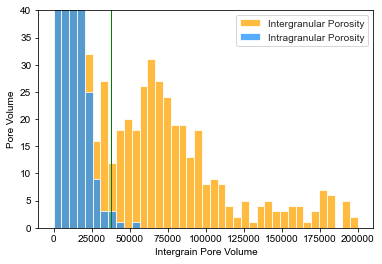

In [12]:
volumeBins = np.linspace(0, 200000, num=40)

fig, ax = plt.subplots()
sns.set_style('whitegrid')

sns.histplot(data=df_secondaryVelocity["Intergrain Pore Volume"],
     bins=volumeBins,color="orange", label="Intergranular Porosity")
sns.histplot(data=df_secondaryVelocity["Intragrain Pore Volume"],
     bins=volumeBins,color="dodgerblue", label="Intragranular Porosity")


#sns.displot(data=[df_secondaryVelocity["Intragrain Pore Volume"], df_secondaryVelocity["Intergrain Pore Volume"]],
#            bins=volumeBins)
plt.ylim([0,40])
plt.legend()
plt.ylabel('Pore Volume')

plt.plot([poreVolumeCutoff, poreVolumeCutoff],[0,200],'g',lw=1)

figStr = 'interAndIntraPoreVolume_pressure_'+str(simPressure)+'.png'

plt.savefig(figStr, dpi=300, facecolor='w', edgecolor='w')


## Plot inter and intragranular porosity


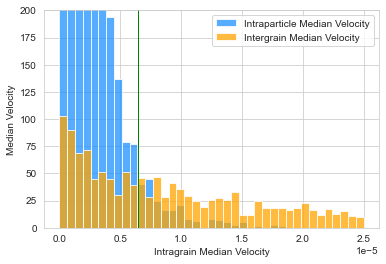

In [13]:
bins = np.linspace(0.000002, 0.00005, num=20)
#np.append(bins,0.0001)
bins = np.append(bins, 1000)
bins = np.insert(bins, 0, 0)
bins = np.insert(bins, 1, 0.00000001)
bins = np.insert(bins, 2, 0.0000001)
bins = np.insert(bins, 3, 0.000001)


binnedIntraVel = pd.cut(df_secondaryVelocity["Intragrain Median Velocity"], bins=bins, right=False)
binnedInterVel = pd.cut(df_secondaryVelocity["Intergrain Median Velocity"], bins=bins, right=False)
df_secondaryVelocity["binned_intraVelocity"] = binnedIntraVel
df_secondaryVelocity["binned_interVelocity"] = binnedIntraVel

yMax = 3000
velBins = np.linspace(0, 0.000025, num=40)

fig, ax = plt.subplots()
#fig.suptitle('Intra and inter pore velocities', fontsize=20)
sns.histplot(data=df_secondaryVelocity["Intragrain Median Velocity"],bins=velBins,
             ax=ax,color="dodgerblue", label="Intraparticle Median Velocity")
sns.histplot(data=df_secondaryVelocity["Intergrain Median Velocity"], bins=velBins,
             ax=ax, color="orange", label="Intergrain Median Velocity")
plt.legend()
ax.set_ylim([0,200])
ax.set_ylabel('Median Velocity')

lowFlowVelCutoff = 6.5 * 10 ** float(-6) #0.000207 # 5.13 * 10 ** float(-5) # 0.5 * 10 ** float(-5)
ax.plot([lowFlowVelCutoff , lowFlowVelCutoff],[0,200],'g',lw=1)

figStr = 'interAndIntraPoreVelocity_pressure_'+str(simPressure)+'.png'

fig.savefig(figStr, dpi=300, facecolor='w', edgecolor='w')



## Plot both pore volume and median velocity

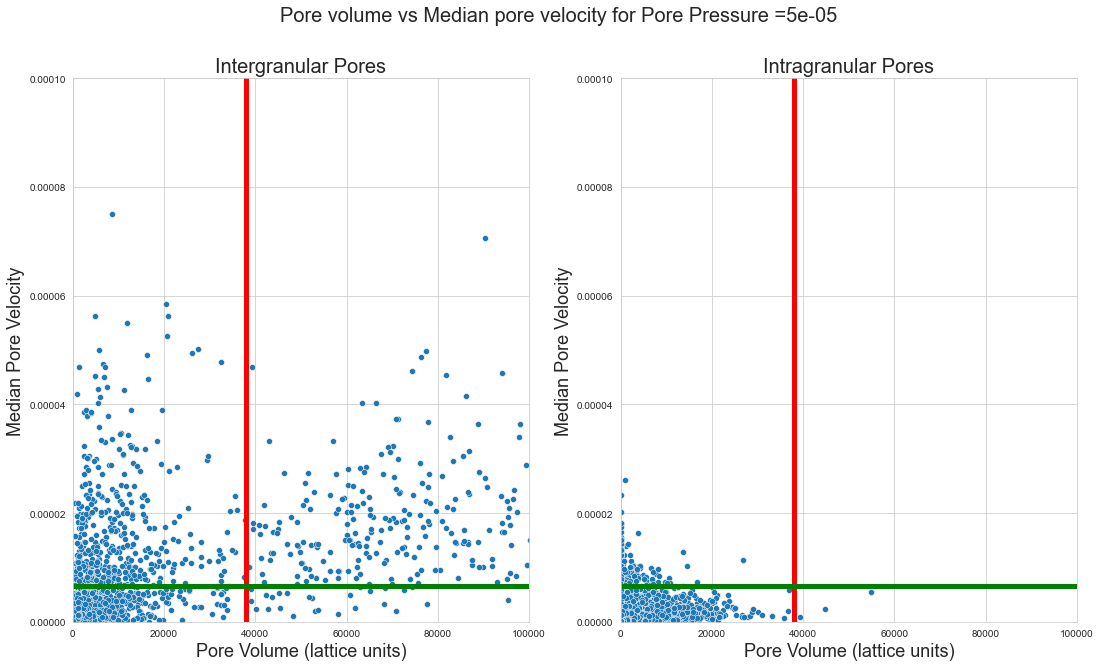

In [14]:
########################################

yMax = 0.0001
xMax = 100000#np.max(df_secondaryVelocity["Intergrain Pore Volume"])

fig, axes = plt.subplots(1, 2, figsize=(18, 10))
fig.suptitle('Pore volume vs Median pore velocity for Pore Pressure ='+str(simPressure), fontsize=20)
sns.scatterplot(data=df_secondaryVelocity,x="Intergrain Pore Volume", y='Intergrain Median Velocity',ax=axes[0])
axes[0].set_xlabel('Pore Volume (lattice units)', fontsize=18)
axes[0].set_ylabel('Median Pore Velocity', fontsize=18)
axes[0].set_title('Intergranular Pores', fontsize=20)
axes[0].set_ylim([0,yMax])
axes[0].set_xlim([0,xMax])
axes[0].plot([poreVolumeCutoff, poreVolumeCutoff],[0,yMax],'r',lw=5)
axes[0].plot([0,np.max(secondarySkeletonPoreVolume)],[lowFlowVelCutoff, lowFlowVelCutoff],'g',lw=5)

sns.scatterplot(data=df_secondaryVelocity, x="Intragrain Pore Volume", y='Intragrain Median Velocity',ax=axes[1])
axes[1].set_xlabel('Pore Volume (lattice units)', fontsize=18)
axes[1].set_ylabel('Median Pore Velocity', fontsize=18)
axes[1].set_title('Intragranular Pores', fontsize=20)
axes[1].set_ylim([0,yMax])
axes[1].set_xlim([0,xMax])
axes[1].plot([poreVolumeCutoff, poreVolumeCutoff],[0,yMax],'r',lw=5)
axes[1].plot([0,np.max(secondarySkeletonPoreVolume)],[lowFlowVelCutoff, lowFlowVelCutoff],'g',lw=5)

figStr = 'poreVolumeVsPoreVelocity_zoomIn'+'.png'

fig.savefig(figStr, dpi=300, facecolor='w', edgecolor='w')


In [15]:
df_secondaryVelocity.count()

All secondary regions             6393
All secondary pore volumes        6393
Median secondary pore velocity    6263
Intragrain Pore Volume            6221
Intragrain Median Velocity        6221
Intergrain Pore Volume            1423
Intergrain Median Velocity        1423
binned_intraVelocity              5951
binned_interVelocity              5951
dtype: int64

# Add diffusion broadening

In [16]:
D_0 = 2.023 * 10 ** float(-9) # for water at twenty degrees Celsius
T = 90 * 10 ** float(-6) # 90 ms, same as NMR experiment
diffusionLength = np.sqrt(D_0 * T)
diffusionVel = diffusionLength/T

randList = [-1,1]
diffusionSign = np.random.choice(randList,len(df_secondaryVelocity["All secondary regions"]))
diffusionDist = np.random.rand(len(df_secondaryVelocity["All secondary regions"]))

# FIXME: how is this defined really?
# figure out sigma of diffusion distribution
diffusionDist = np.random.normal(0,diffusionVel,len(df_secondaryVelocity["All secondary regions"]))
#diffusionDistScale = (diffusionDist-np.mean(diffusionDist)) / np.std(diffusionDist)
diffusionDistScale = (diffusionDist-np.min(diffusionDist)) / (np.max(diffusionDist)-np.min(diffusionDist))
diffusionDistScale = diffusionDistScale - np.mean(diffusionDistScale)
#diffusionAdd = diffusionAdd / np.mean(diffusionAdd)

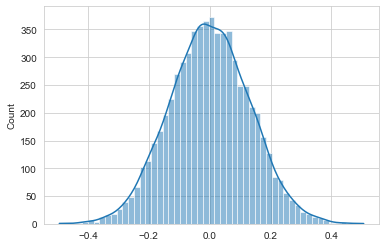

In [17]:
fig, ax = plt.subplots()

sns.histplot(diffusionDistScale,kde=True)

figStr = 'diffDist'+'.png'

fig.savefig(figStr, dpi=300, facecolor='w', edgecolor='w')

In [ ]:
secondaryMedianVel = df_secondaryVelocity["Median secondary pore velocity"]
secondaryMedianVel = np.array(secondaryMedianVel)
#secondaryVelScale = (secondaryMedianVel - np.nanmean(secondaryMedianVel)) / np.nanstd(secondaryMedianVel)
secondaryVelScale = (secondaryMedianVel - np.nanmin(secondaryMedianVel)) / (np.nanmax(secondaryMedianVel) - np.nanmin(secondaryMedianVel))

In [ ]:
fig, ax = plt.subplots()

sns.histplot(secondaryVelScale)

figStr = 'simVelDist'+'.png'

fig.savefig(figStr, dpi=300, facecolor='w', edgecolor='w')

### Plot all pore velocities

In [18]:
# filter by pore space
allVelocities = velDataNormSecondary[secondaryImage == True]
# smush into one dimension
allVelocities = np.squeeze(allVelocities)
# normalize by mean velocity
allVelocitiesNorm = allVelocities / np.mean(allVelocities)

In [19]:
allDisplacementNorm = allVelocitiesNorm * resolution * experimentTime # this is now in units of length

In [20]:
bins = np.linspace(0.000002, 0.00005, num=20)
#np.append(bins,0.0001)
bins = np.append(bins, 1000)
bins = np.insert(bins, 0, 0)
bins = np.insert(bins, 1, 0.00000001)
bins = np.insert(bins, 2, 0.0000001)
bins = np.insert(bins, 3, 0.000001)

binnedAllDisplacements = pd.cut(allDisplacementNorm, bins=bins, right=False)


In [ ]:
sns.histplot(allVelocitiesNorm)

In [ ]:
fig, ax = plt.subplots()

sns.histplot(allDisplacementNorm)

figStr = 'simulatedDisplacement'+'.png'

fig.savefig(figStr, dpi=300, facecolor='w', edgecolor='w')

## Load NMR data

In [ ]:
filePath = cwd / 'summedNMRDisp.mat'
NMR_dispData = sio.loadmat(filePath)
NMRDisp = NMR_dispData['summedDispData']

In [ ]:
NMRDispScale = (NMRDisp - np.nanmean(NMRDisp)) / (np.nanmax(NMRDisp)-np.nanmin(NMRDisp))
NMRDispScale = np.transpose(NMRDispScale)
NMRDispScale = np.squeeze(NMRDispScale)

In [ ]:
indices = [i for i in range(NMRDispScale.size)]

In [ ]:
fig, ax = plt.subplots()

plt.plot(indices,NMRDispScale,axes=ax)

figStr = 'NMRDispHist'+'.png'

fig.savefig(figStr, dpi=300, facecolor='w', edgecolor='w')




In [ ]:
 np.where(secondaryVelPlusDiffusion[3] == np.nan)

In [ ]:
indices = [i for i in range(secondaryVelScale.size)]
secondaryVelScale = np.sort(secondaryVelScale)
secondaryVelScale = np.flip(secondaryVelScale)
plt.plot(indices,secondaryVelScale)


In [ ]:
secondaryVelPlusDiffusion = secondaryVelScale + diffusionDistScale

fig, ax = plt.subplots()

sns.histplot(secondaryVelPlusDiffusion,ax=ax,kde=True)

figStr = 'simDispHist'+'.png'

fig.savefig(figStr, dpi=300, facecolor='w', edgecolor='w')

In [ ]:
indices = np.where(np.isnan(secondaryVelPlusDiffusion), False, True)
secondaryVelPlusDiffusion = secondaryVelPlusDiffusion[indices]

In [ ]:
indices = [i for i in range(secondaryVelPlusDiffusion.size)]
plt.plot(indices,secondaryVelPlusDiffusion)

In [ ]:
testKDE = gaussian_kde(secondaryVelPlusDiffusion)
indices = np.random.rand(len(secondaryVelPlusDiffusion))
plotKDE = testKDE.evaluate(indices)

In [ ]:
plt.plot(indices,plotKDE)


In [ ]:
np.random.rand(10)

In [ ]:
filePath = cwd / 'summedNMRDisp.mat'
NMR_dispData = sio.loadmat(filePath)
NMRDisp = NMR_dispData['summedDispData']

In [ ]:
NMRDispScale = (NMRDisp - np.nanmean(NMRDisp)) / (np.nanmax(NMRDisp)-np.nanmin(NMRDisp))
NMRDispScale = np.transpose(NMRDispScale)
NMRDispScale = np.squeeze(NMRDispScale)

In [ ]:
indices = [i for i in range(NMRDispScale.size)]

In [ ]:
fig, ax = plt.subplots()

plt.plot(indices,NMRDispScale,axes=ax)

figStr = 'NMRDispHist'+'.png'

fig.savefig(figStr, dpi=300, facecolor='w', edgecolor='w')



# Calculate flowing fraction for this data

In [ ]:
intergrainPoreCount = df_secondaryVelocity["Intergrain Pore Volume"].count()
print('Number of inter particle pores is',str(intergrainPoreCount))

# Final porosity calculation
porosityCalc = ps.metrics.porosity(secondaryImage)
print('Total porosity:')
print(np.round(porosityCalc,2))

# Get grains
flippedImage = np.copy(secondaryImage)
flippedImage[secondaryImage == 1] = 0
flippedImage[secondaryImage == 0] = 1

### Refer to other code for less/more mobile calculation
## lowFlowCompute.py